In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM2D import TMCRBM2D
import functions

from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

# RBM Tethered Monte-Carlo Sampling 2D
### Data : 
 - $N_v = 1000$
 - $N_s = 12000$
 - 3 clusters along 2 dimension

In [2]:
data = torch.load('../dataset/data_2d.pt')


In [3]:
fname = "../model/TMC2D/AllParametersTMC2DRBM_NGibbs_70_Nh100_Nv1000_Nmb200_Nepoch50_lr_0.001_N20000_Npoint2500_Nchain10_phase3.h5"
f = h5py.File(fname, "r")
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
alltimes = np.array(alltimes)

In [4]:
t = 990
lr = 0.01
NGibbs = 70
annSteps = 0
mb_s = 600
num_pcd = 600
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 50
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 50 # Nb it_mcmc pour chaque chaine
it_mean = 40 # Nb it considérée pour la moyenne temporelle de chaque chaine
nDim = 2
nb_point_dim = torch.tensor([50,50]) # -> doit avoir autant de terme que la valeur de nDim
N = 10000
border_length = 0.4

In [5]:
myRBM = TMCRBM2D(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )
myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)
if torch.mean(V[:,0])<0:
    V = -V

In [6]:
proj_data =torch.mm(data, V).cpu()/myRBM.Nv**.5
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 10000), device=myRBM.device, dtype=myRBM.dtype))

si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=1000)
proj_gen = torch.mm(si.T, V).cpu().numpy()/myRBM.Nv**.5

In [7]:
square, p_m, w_hat_tmp = functions.ComputeProbabilityTMC2D(myRBM, data, nb_chain, it_mcmc, it_mean, N, nb_point_dim, border_length, device)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<ipython-input-8-482988bb9481>:3: RuntimeWarning: divide by zero encountered in log
  plt.contour(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 10)


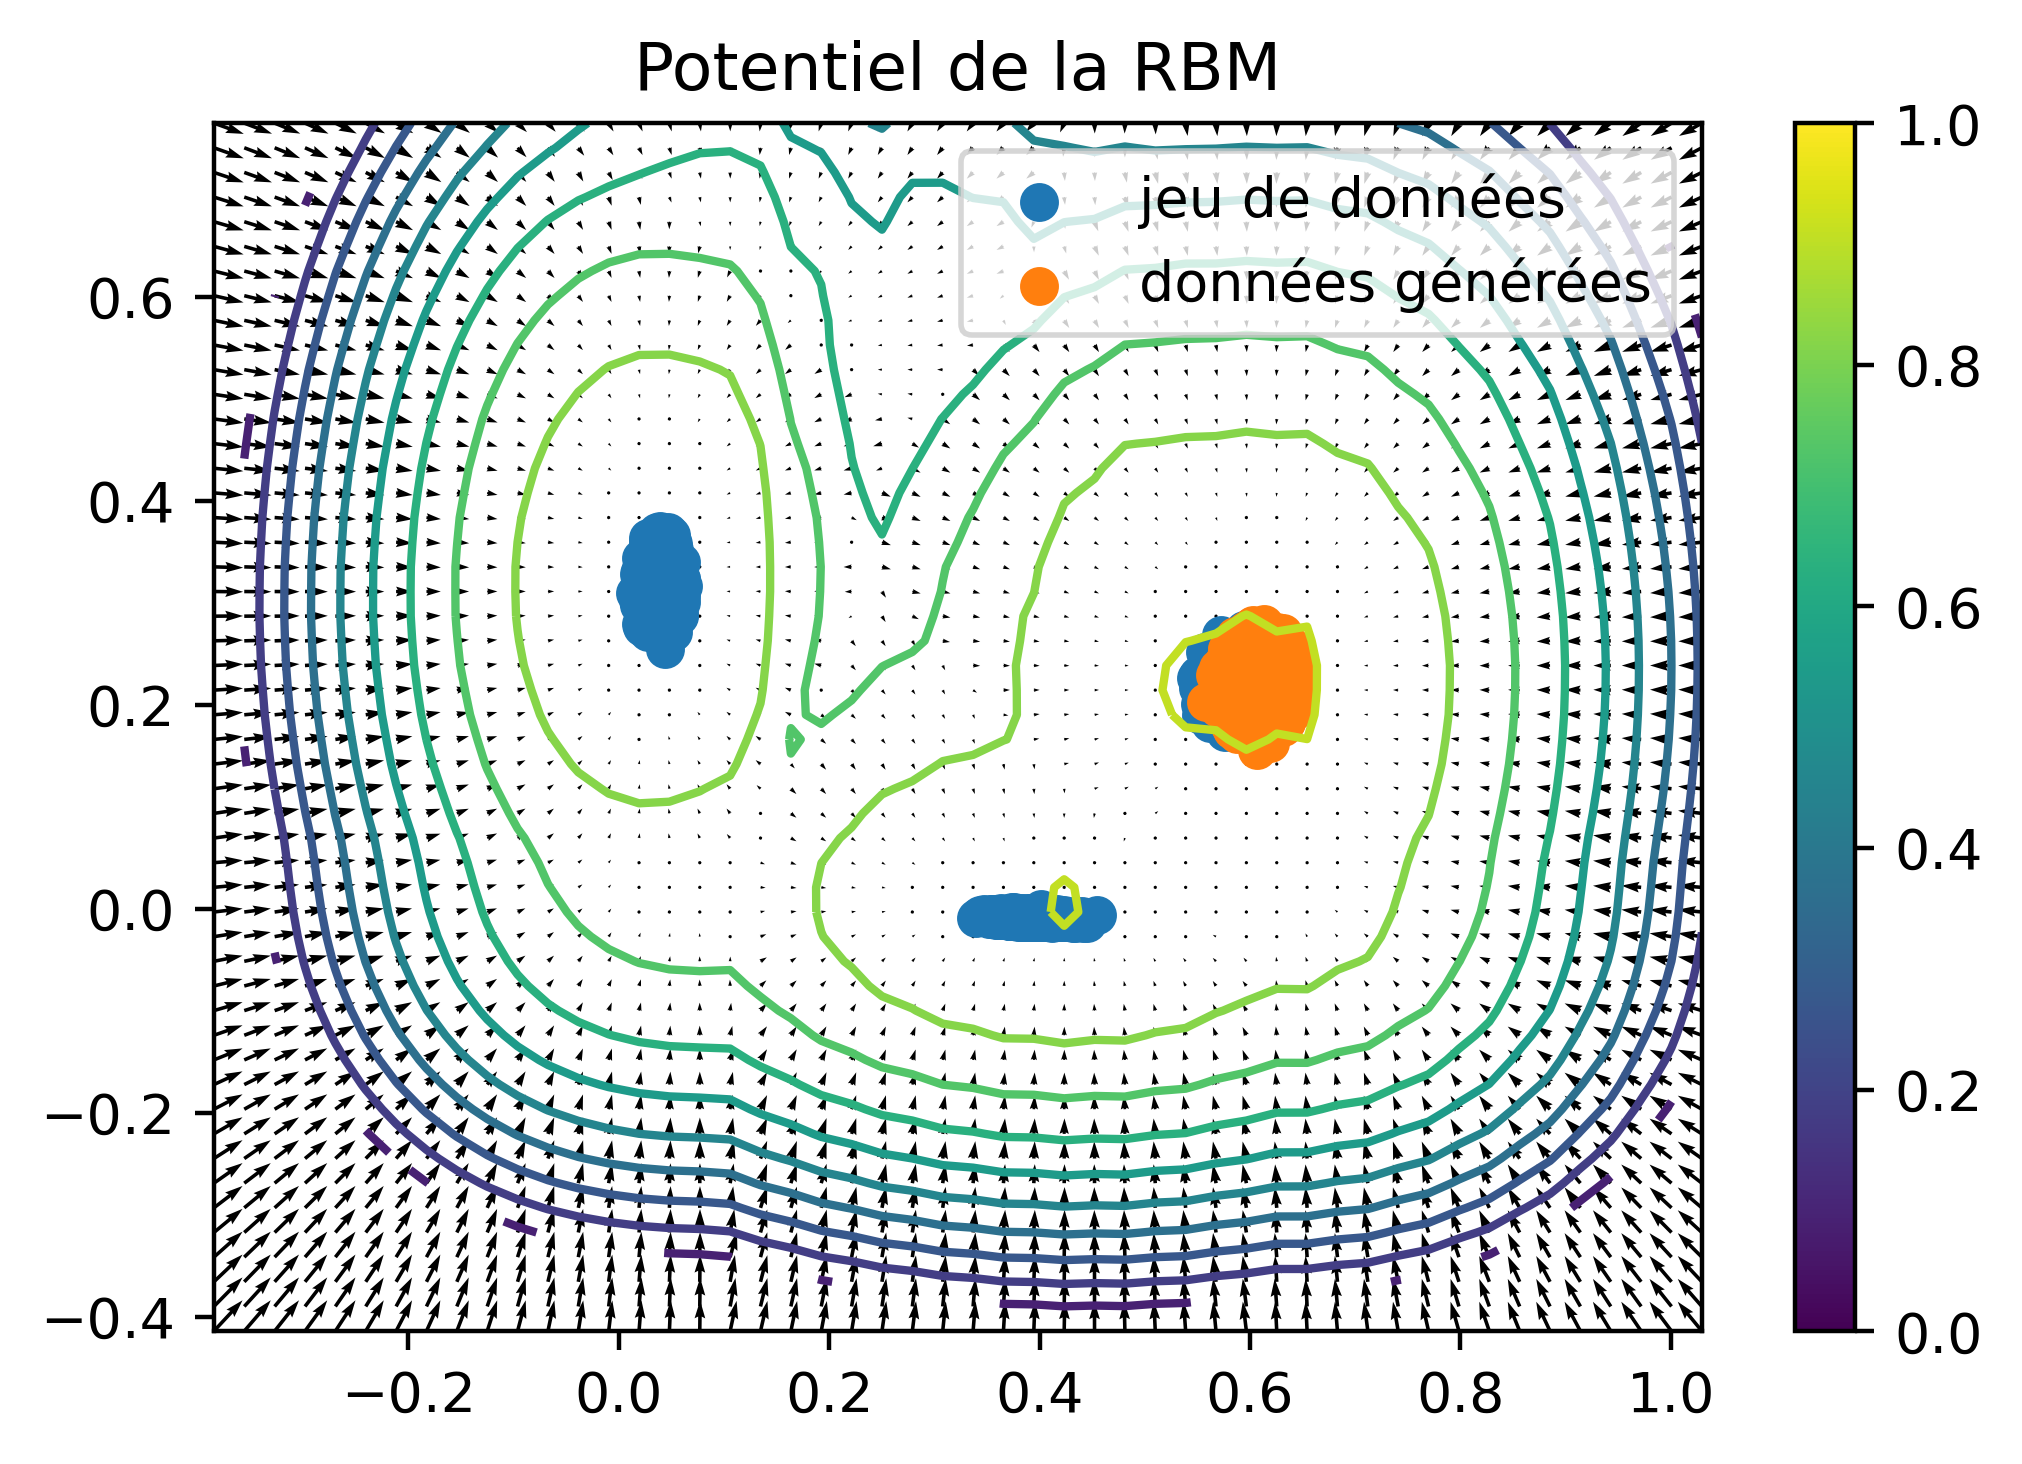

In [8]:

plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 10)
plt.scatter(proj_data[:,0], proj_data[:,1], label = "jeu de données")
plt.scatter(proj_gen[:,0], proj_gen[:,1], label = "données générées")
plt.legend()
plt.title("Potentiel de la RBM")
plt.colorbar()
plt.savefig("../../Stage/rapport/fig/potentialTMC2D.png")

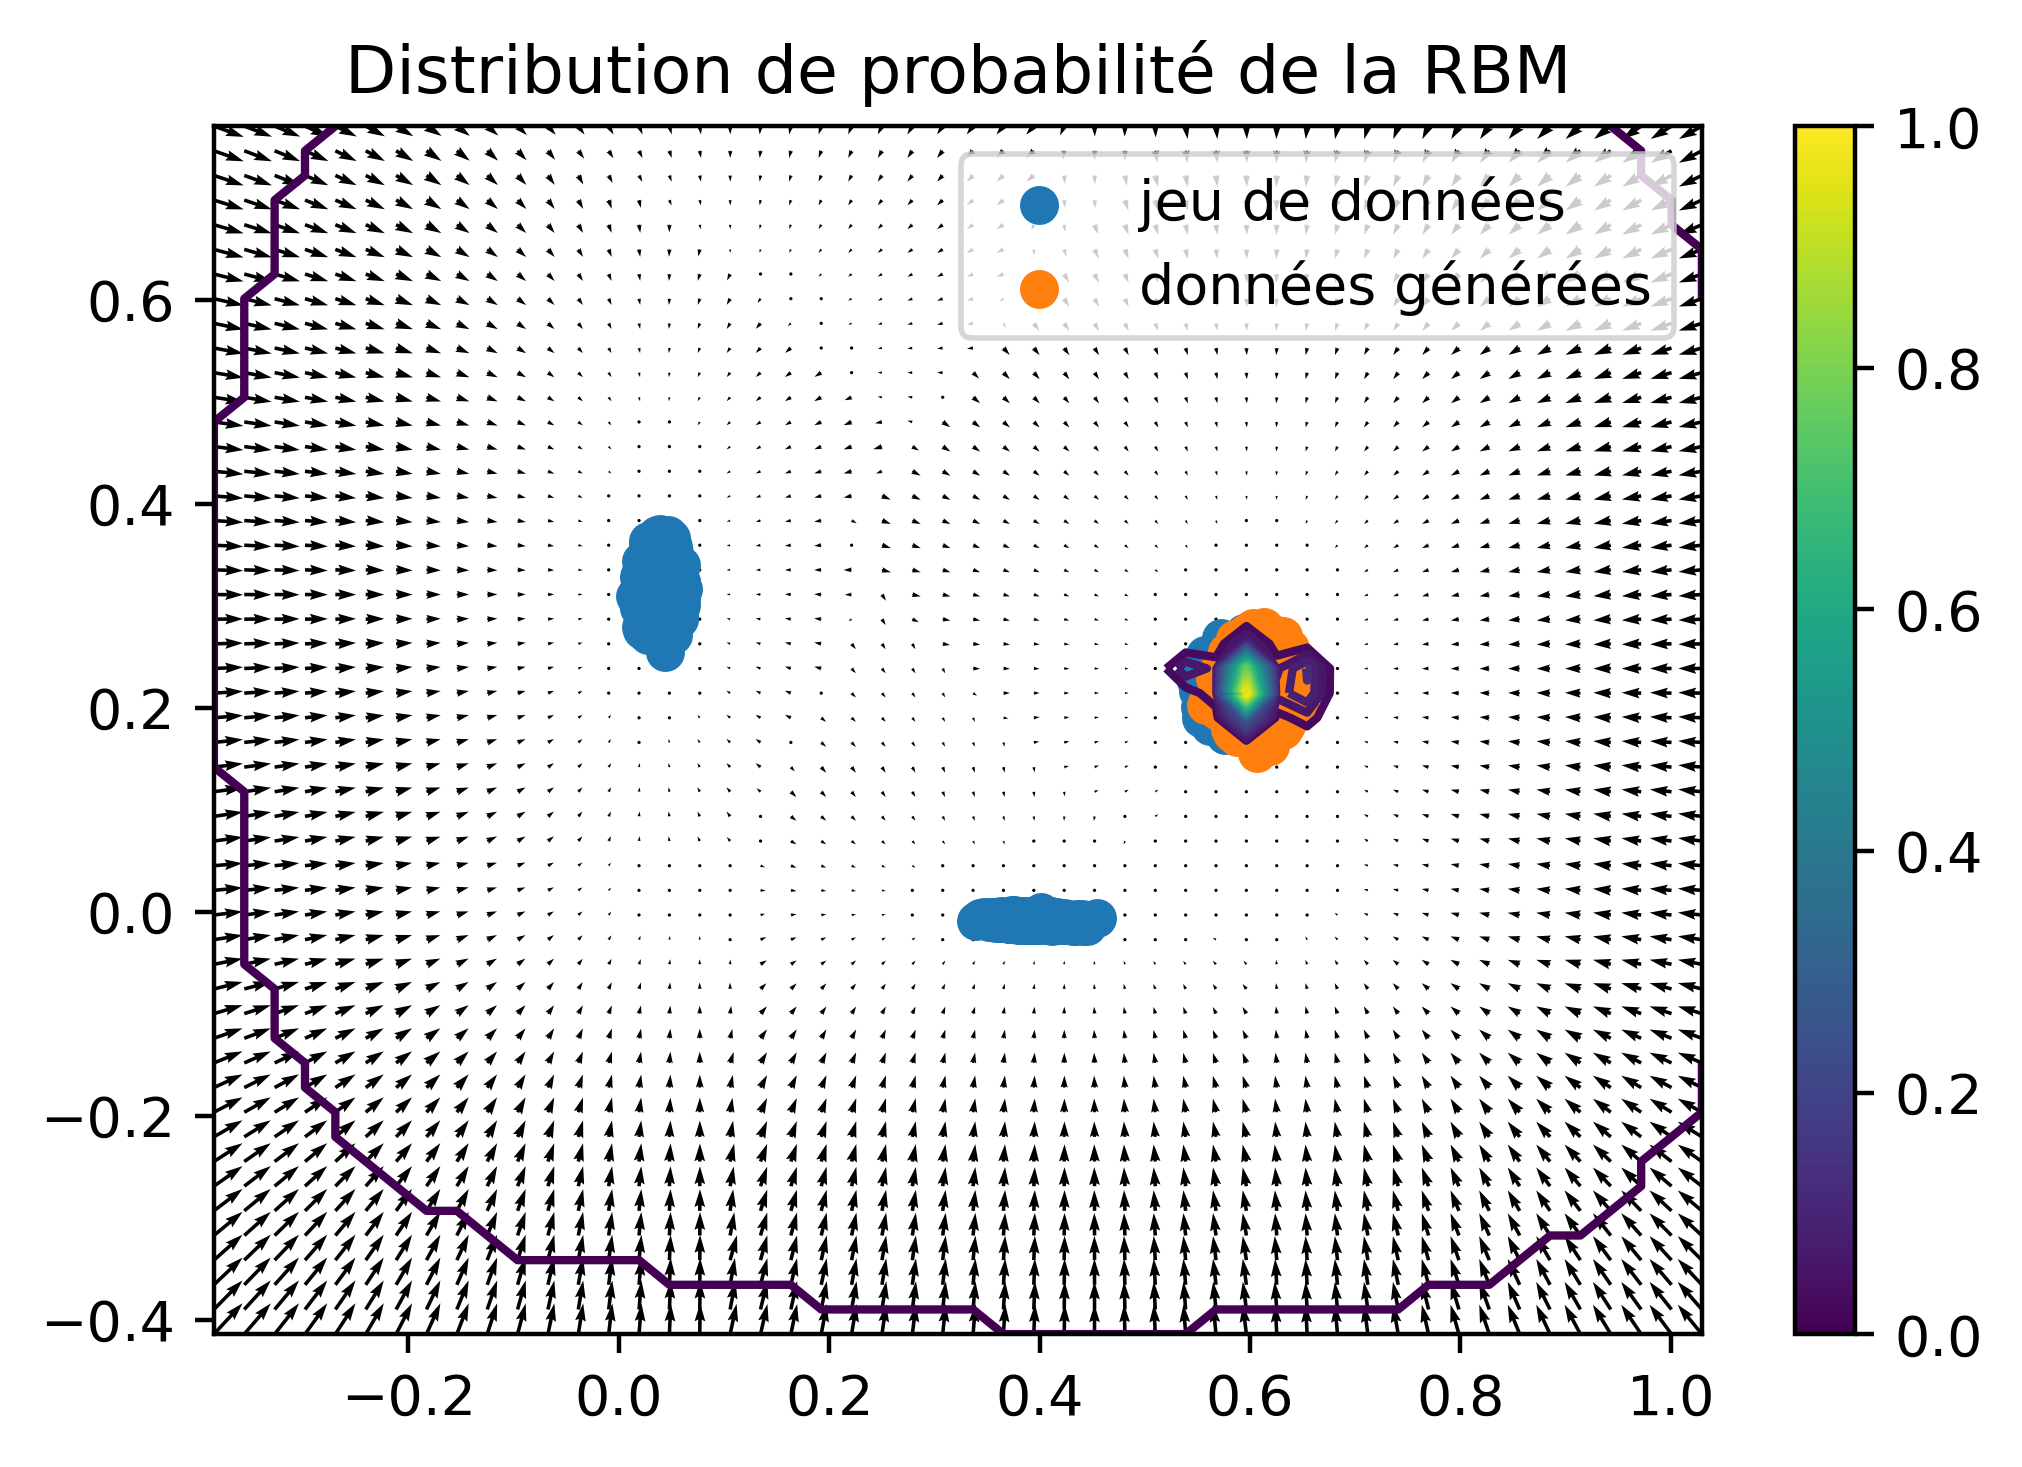

In [9]:

plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], p_m, 40)
plt.scatter(proj_data[:,0], proj_data[:,1], label = "jeu de données")
plt.scatter(proj_gen[:,0], proj_gen[:,1], label = "données générées")
plt.legend()
plt.title("Distribution de probabilité de la RBM")
plt.colorbar()
plt.savefig("../../Stage/rapport/fig/probabilityTMC2D.png")

<ipython-input-10-7f4ef03ae6e3>:11: RuntimeWarning: divide by zero encountered in log
  im2 = ax[1].contourf(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 40)


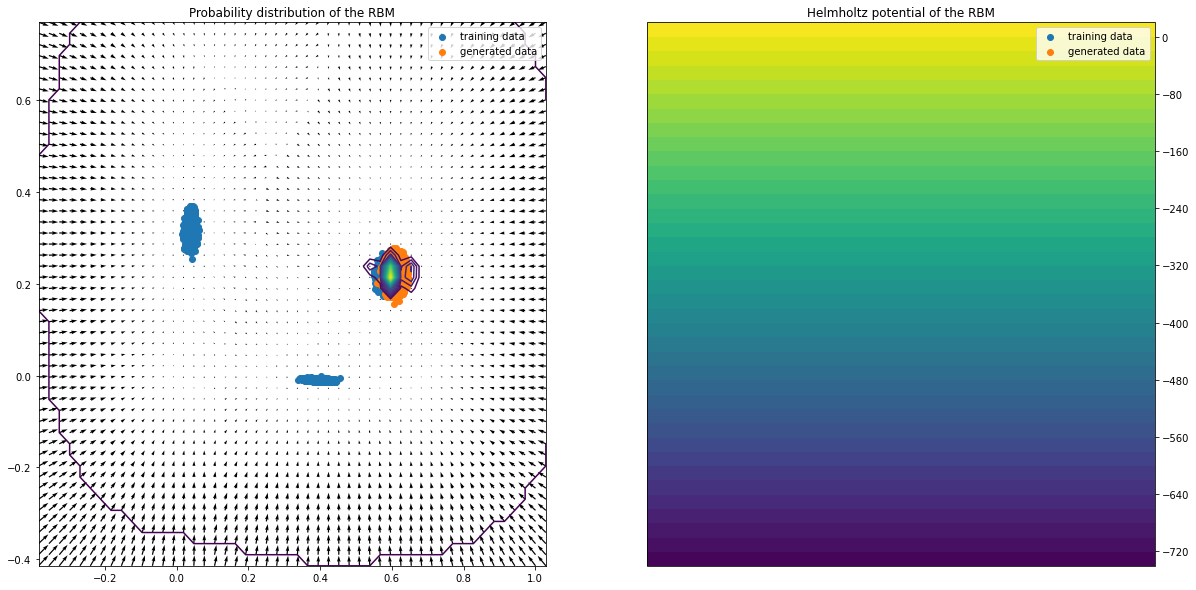

In [10]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
ax[0].quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
im1 = ax[0].contour(w_hat_tmp[0],w_hat_tmp[1], p_m, 40)
ax[0].scatter(proj_data[:,0], proj_data[:,1], label = "training data")
ax[0].scatter(proj_gen[:,0], proj_gen[:,1], label = "generated data")
ax[0].legend(loc=1)
ax[0].set_title("Probability distribution of the RBM")
#fig.colorbar(im1,ax[0])

ax[1].quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
im2 = ax[1].contourf(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 40)
ax[1].scatter(proj_data[:,0], proj_data[:,1], label = "training data")
ax[1].scatter(proj_gen[:,0], proj_gen[:,1], label = "generated data")
ax[1].legend(loc=1)
ax[1].set_title("Helmholtz potential of the RBM")
fig.colorbar(im2, ax[1])